### 假设已知十年国债收益率情形下验证论文结论

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import fortitudo.tech as ft
import scipy.io as scio
import pypfopt as pfopt
from numba import njit
from datetime import datetime
import statsmodels.api as sm

In [5]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [6]:
start_date = '2007-01-01'
end_date = '2023-08-21'

In [7]:
A300 = pd.read_excel('A300_daily.xls').dropna()
A500 = pd.read_excel('A500_daily.xls').dropna()
SPX = pd.read_excel('SPX_daily.xls').dropna()
HSI = pd.read_excel('HSI_daily.xls').dropna()
AU9999 = pd.read_excel('AU9999_daily.xls').dropna()
CNbd = pd.read_excel('China_bond.xlsx').dropna()
CN10y = pd.read_excel('China_bond10y.xls').dropna()
SPX_VIX = pd.read_excel('SPX_VIX_daily.xls').dropna()

indices = {'A300':A300, 'A500':A500, 'SPX':SPX, 'HSI':HSI, 'AU9999':AU9999, 'CNbd': CNbd, 'CN10y': CN10y, 'SPX_VIX': SPX_VIX}
names = ['A300', 'A500', 'SPX', 'HSI', 'AU9999', 'CNbd', 'CN10y', 'SPX_VIX']
datalen = [index.shape[1] for name, index in indices.items()]

# 清洗数据
for name, index in indices.items():
    index = index.dropna()
    index = index[(index['交易时间'] >= start_date) & (index['交易时间'] <= end_date)]
    index = index.reset_index(drop=True)
    indices[name] = index   

#同步时间序列，直接删除不同市场区域不匹配的交易时间
for mg_name in names:
    for name, index in indices.items():
        if name== mg_name: continue
        datalen = index.shape[1]
        index = pd.merge(index, indices[mg_name], on='交易时间', how='inner', suffixes=('','_2')).iloc[:,:datalen]
        indices[name] = index
for name, index in indices.items():
    index.reset_index(drop=True, inplace=True)

In [8]:
# 因为重新同步了市场时间，所以需要重新计算涨跌幅
for name, index in indices.items():
    for i in range(1,index.shape[0]): #第0天不算了
        if name != 'CN10y':
            index.loc[i,'涨跌'] = index['收盘价'][i] - index['收盘价'][i-1]
            index.loc[i,'涨跌幅%'] = index.loc[i,'涨跌'] / index.loc[i-1,'收盘价'] * 100
        else:
            index.loc[i,'涨跌幅%'] = (index['收盘价'][i] - index['收盘价'][i-1]) / index.loc[i-1,'收盘价'] * 100
    index.fillna(0,inplace=True)

SPX_VIX = indices['SPX_VIX']
del indices['SPX_VIX']
names.pop()

CN10y = indices['CN10y']
#del indices['CN10y']
#names.pop()

In [10]:
pnls = np.array([[0] * indices['A300'].shape[0]])    # 把涨跌幅做成矩阵方便使用
names = []
for name, index in indices.items():
    names.append(name)
    pnls = np.r_[pnls, np.array(index['涨跌幅%']).reshape(1,-1)]
pnls = pd.DataFrame(pnls[1:].astype('float64').T,columns = names)
display(pnls)

,A300,A500,SPX,HSI,AU9999,CNbd,CN10y
0,1.275816,-0.142518,0.122829,-1.899785,-0.476964,0.000000,-1.910000
1,0.280104,2.714525,-0.608458,0.927314,-1.034178,0.081371,0.264638
2,2.830844,4.602142,0.222031,-0.898607,-2.051740,-0.045391,-0.329924
3,3.215016,2.155014,-0.051669,-0.656926,0.474889,0.108988,0.297915
4,2.539896,2.587916,0.194036,-1.657145,-0.071220,0.151142,0.396040
...,...,...,...,...,...,...,...
3815,-0.729793,0.058376,0.575038,-1.581321,0.153762,0.151371,-0.942685
3816,-0.243030,-0.625743,-1.155083,-1.025059,0.010966,0.218419,-1.560716
3817,-0.733179,-0.791918,-0.755544,-1.355194,0.173246,0.151834,-0.077340
3818,0.334361,0.705357,-0.771286,-0.014567,-0.019703,-0.030375,-0.425697


In [11]:
# 计算期望与协方差

Mu = pnls.mean(axis = 0)
Sigma = pnls.cov()
display(np.round(Mu,3))
display(np.round(pnls.corr(), 2))   # 相关系数矩阵
display(np.round(Sigma, 2))  # 协方差矩阵

A300      0.031
A500      0.051
SPX       0.038
HSI       0.009
AU9999    0.033
CNbd      0.016
CN10y     0.007
dtype: float64

,A300,A500,SPX,HSI,AU9999,CNbd,CN10y
A300,1.00,0.88,0.12,0.54,0.06,-0.08,0.02
A500,0.88,1.00,0.09,0.42,0.05,-0.06,0.02
SPX,0.12,0.09,1.00,0.26,0.00,-0.04,0.04
HSI,0.54,0.42,0.26,1.00,0.10,-0.09,0.03
AU9999,0.06,0.05,0.00,0.10,1.00,0.05,-0.03
CNbd,-0.08,-0.06,-0.04,-0.09,0.05,1.00,-0.22
CN10y,0.02,0.02,0.04,0.03,-0.03,-0.22,1.00


,A300,A500,SPX,HSI,AU9999,CNbd,CN10y
A300,2.99,2.98,0.28,1.50,0.10,-0.03,0.06
A500,2.98,3.82,0.24,1.31,0.09,-0.02,0.07
SPX,0.28,0.24,1.78,0.56,0.01,-0.01,0.08
HSI,1.50,1.31,0.56,2.55,0.16,-0.03,0.07
AU9999,0.10,0.09,0.01,0.16,1.05,0.01,-0.04
CNbd,-0.03,-0.02,-0.01,-0.03,0.01,0.04,-0.07
CN10y,0.06,0.07,0.08,0.07,-0.04,-0.07,2.33


In [12]:
@njit    #numba加速，需要明确定义数据类型
def price_MonteCarlo(sim_times:int, n_ptf:int, R:np.ndarray, p:np.ndarray) -> np.ndarray:
    '''
    只记录模拟结束的价格
    '''
    def rand_choice_nb(arr:np.ndarray, prob:np.ndarray) -> np.ndarray:
        """
        :param arr: A 1D numpy array of values to sample from.
        :param prob: A 1D numpy array of probabilities for the given samples.
        :return: A random sample from the given array with a given probability.
        """
        return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

    all_choice = np.arange(R.shape[0])
    
    sim_end_time = 20
    sim_series = np.zeros((sim_times, n_ptf))
    for i in range(sim_times):
        now_price = np.ones(n_ptf,dtype=np.float64)
        for t in range(sim_end_time):
            #scene = np.random.choice(all_choice, p = p.ravel()) # p parameter is not supported
            scene = rand_choice_nb(all_choice, p)
            drive = R[scene]
            now_price = now_price * (1 + drive * 0.01)
        sim_series[i, :] = now_price
    return sim_series

@njit    #numba加速，需要明确定义数据类型
def path_MonteCarlo(sim_times:int, n_ptf:int, R:np.ndarray, p:np.ndarray) -> np.ndarray:
    '''
    记录整个模拟的价格路径
    '''
    def rand_choice_nb(arr:np.ndarray, prob:np.ndarray) -> np.ndarray:
        """
        :param arr: A 1D numpy array of values to sample from.
        :param prob: A 1D numpy array of probabilities for the given samples.
        :return: A random sample from the given array with a given probability.
        """
        return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

    all_choice = np.arange(R.shape[0])
    
    sim_end_time = 20
    sim_paths = np.zeros((sim_times, n_ptf,  sim_end_time))
    for i in range(sim_times):
        now_price = np.ones(n_ptf,dtype=np.float64)
        for t in range(sim_end_time):
            #scene = np.random.choice(all_choice, p = p.ravel()) # p parameter is not supported
            scene = rand_choice_nb(all_choice, p)
            drive = R[scene]
            now_price = now_price * (1 + drive * 0.01)
            sim_paths[i, :, t] = now_price
    return sim_paths

In [57]:
def draw_ptf():
    fig = plt.figure(figsize = (12,10))

    time_series = np.arange(begin_time-adj_period, end_time+1,adj_period)
    port_series = opt1_port
    norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

    color = ['red', 'blue', 'orange', 'green', 'pink', 'magenta', 'grey', 'black']

    ax = fig.add_subplot(211)
    for i in range(3):
        ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Indices')
    ax.legend(loc = 'upper left')

    ax2 = ax.twinx()
    for i in range(3):
        ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
    ax2.set_ylabel('Proportion')
    ax2.legend(loc = 'upper right')

    ax.grid()

    ax = fig.add_subplot(212)
    for i in range(3,n_ptf):
        ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Indices')
    ax.legend(loc = 'upper left')

    ax2 = ax.twinx()
    for i in range(3,n_ptf + 1):
        ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
    ax2.set_ylabel('Proportion')
    ax2.legend(loc = 'upper right')

    ax.grid()
    
def draw_profit():
    color = ['red', 'blue', 'orange', 'green', 'pink', 'magenta', 'grey', 'black']
    norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

    portfo = np.array([.0,.0,.0,.0,.0,.0,.0,1])
    value_series = []
    for time in range(begin_time - adj_period, end_time+1, adj_period):
        # 简单起见，不考虑手续费，先把所有东西卖了然后再买入
        if time == end_time +  adj_period:
            prices_now = norm_prices[:,(time - (begin_time -  adj_period))//adj_period]
            for i in range(n_ptf):
                portfo[n_ptf] += portfo[i] * prices_now[i]
                portfo[i] = .0
            value_series.append(portfo[n_ptf])
            break
        prices_now = norm_prices[:,(time - (begin_time - adj_period))//adj_period]
        for i in range(n_ptf):
            portfo[n_ptf] += portfo[i] * prices_now[i]
            portfo[i] = .0
        ptf_portion = opt1_port.loc[:,time]
        value_series.append(portfo[n_ptf])

        for i in range(n_ptf):
            portfo[i] += portfo[n_ptf] * ptf_portion[i] *0.01 / prices_now[i]
        portfo[n_ptf] -= ptf_portion[:n_ptf].sum() * 0.01 * portfo[n_ptf]

    fig = plt.figure(figsize=(12,8))

    time_series = np.arange(begin_time- adj_period, end_time+1,20)
    plt.subplot(211)
    plt.ticklabel_format(style='plain')
    plt.xlabel('days')
    plt.ylabel('Value')
    for i in range(n_ptf):
        plt.plot(time_series, norm_prices[i,:], '--', label = names[i], color = color[i])
    plt.plot(time_series, value_series, label='My Portfolio')
    plt.legend()
    plt.grid()

    plt.subplot(212)
    plt.ticklabel_format(style='plain')
    plt.xlabel('days')
    plt.ylabel('Value')
    plt.plot(time_series, value_series, label='My Portfolio')
    plt.legend()
    plt.grid()

    time1 = datetime.strptime(str(indices['A300']['交易时间'][begin_time-adj_period])[:10],"%Y-%m-%d")
    time2 = datetime.strptime(str(indices['A300']['交易时间'][end_time])[:10],"%Y-%m-%d")
    duration_years = (time2 - time1).days / 365
    
    print('Start Date:', str(indices['A300']['交易时间'][begin_time-adj_period])[:10])
    print('End Date:', str(indices['A300']['交易时间'][end_time])[:10])
    print(f'Yearly Earning: {np.round((value_series[-1]**(1/duration_years) - 1) * 100,2)}%')
    down_window = 252
    roll_value = pd.DataFrame(value_series)
    roll_max = roll_value.rolling(down_window, min_periods=1).max()
    daily_drawdown = roll_value/roll_max - 1.0
    max_daily_drawdown = daily_drawdown.rolling(down_window, min_periods=1).min()
    print(f'Yearly Maximum Drawdown: {np.round(max_daily_drawdown.min()[0] * 100,2)}%')

In [14]:
def RSI(price, price_move, period = 12):
    rsi = np.array([0] * period)
    avg_gain = np.array([0] * period)
    avg_loss = np.array([0] * period)

    sub_move = price_move[1: period + 1]
    _avg_gain = np.sum(sub_move[sub_move >= 0])/period
    _avg_loss = np.sum(-sub_move[sub_move < 0])/period
    avg_gain = np.append(avg_gain, _avg_gain)
    avg_loss = np.append(avg_loss, _avg_loss)
    rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    
    for i in range(period + 1, price.shape[0]):
        _avg_gain = (avg_gain[i - 1] * (period - 1) + max(price_move[i], 0)) / period
        _avg_loss = (avg_loss[i - 1] * (period - 1) + max(-price_move[i], 0)) / period
        avg_gain = np.append(avg_gain, _avg_gain)
        avg_loss = np.append(avg_loss, _avg_loss)
        rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    return rsi

def momentum(prices, day_ago):
    diff = np.c_[prices[:, :day_ago], prices][:,:-day_ago]
    return (prices - diff) / diff

In [15]:
prices = []
for name, index in indices.items():
    prices.append(index['收盘价'])
prices = np.array(prices)

price_moves = []
for i in range(prices.shape[0]):
    price_moves.append([0])
    for j in range(1, prices.shape[1]):
        price_moves[i].append(prices[i][j] - prices[i][j - 1])
price_moves = np.array(price_moves)

In [137]:
begin_time = 247
end_time = 2997
adj_period = 20
n_ptf = pnls.shape[1]    # Portfolio number (no cash)

In [138]:
RSIs = []
for i in range(n_ptf):
    _RSI =  RSI(prices[i], price_moves[i], period = 20)
    RSIs.append(_RSI)
RSIs = np.array(RSIs)
RSIs

array([[ 0.        ,  0.        ,  0.        , ..., 41.49285065,
        42.82572993, 39.34513341],
       [ 0.        ,  0.        ,  0.        , ..., 37.42276337,
        40.75689493, 36.01627417],
       [ 0.        ,  0.        ,  0.        , ..., 46.8056002 ,
        43.87562566, 43.82037514],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 55.91868113,
        55.74416186, 54.5494532 ],
       [ 0.        ,  0.        ,  0.        , ..., 78.48437983,
        76.9576826 , 77.60028929],
       [ 0.        ,  0.        ,  0.        , ..., 30.31057041,
        28.94715224, 28.57811221]])

In [139]:
MTMs = momentum(prices, 20)

In [140]:
names = ['A300', 'A500', 'SPX', 'HSI', 'AU9999', 'CNbd', 'CN10y']
R_df = pd.DataFrame(data=pnls[0:begin_time], columns=names)
instrument_names = R_df.columns

print('原始数据')
# Print prior P&L stats
stats_prior = ft.simulation_moments(R_df)
display(stats_prior)

原始数据


,Mean,Volatility,Skewness,Kurtosis
A300,0.372544,2.561535,-1.098160,6.263918
A500,0.461828,2.890587,-1.129223,5.581408
SPX,-0.011650,1.103273,-0.390196,3.650630
HSI,0.081597,2.083357,-0.622045,12.659565
AU9999,0.123915,0.941834,-0.202003,4.196191
CNbd,-0.016929,0.224825,-0.269866,7.984207
CN10y,0.161790,2.326711,0.520808,6.446493


In [141]:
@njit  # 加速加速太慢了
def MC_p(this_ptf: np.ndarray, last_ptf: np.ndarray, paths: np.ndarray) -> float:
    '''
    计算Monte Carlo模拟的概率
    last_ptf: 上月持仓比例
    this_ptf: 本月持仓比例
    paths: 模拟的路径
    '''
    def maximum_accumulate(A):
        r = np.empty(len(A))
        t = -np.inf
        for i in range(len(A)):
            t = np.maximum(t, A[i])
            r[i] = t
        return r
    last_ptf /= last_ptf.sum()   # 持仓比例归一化
    this_ptf /= this_ptf.sum()
    
    trade_cost = np.abs(this_ptf - last_ptf).sum() * 0.005 / 2
    
    cnt = 0   # 频率统计
    
    for i in range(paths.shape[0]):
        path = paths[i]
        value_series = path.T @ this_ptf[:-1] + this_ptf[-1] # 计算给定path在当月持仓下的价值变化（非现金资产 + 现金）
        p = np.argmax(maximum_accumulate(value_series) - value_series)
        if p == 0:
            max_drawdown = 0
        else:
            q = np.argmax(value_series[:p])
            max_drawdown = (value_series[p] - value_series[q]) / value_series[q]
        
        earning = value_series[-1] - 1
        if max_drawdown <= -0.006 or earning <= 0.01 + trade_cost:
            cnt += 1
    return cnt / paths.shape[0]

### 假设已知十年国债收益率

In [161]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([2.,3.,1.,0.,44.,50.,0, 0.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[0:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:,6]))  # known 10y rate
    b = np.array(1.0,dtype=np.float64)
    b = np.append(b, (np.power((CN10y.iloc[time + 20]['收盘价'] / CN10y.iloc[time]['收盘价']), 1/20) - 1)*100)
    print((np.power((CN10y.iloc[time + 20]['收盘价'] / CN10y.iloc[time]['收盘价']), 1/20) - 1)*100)
    b = b.reshape(-1,1)
    q = ft.entropy_pooling(p, A, b)    # Post distribution
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_paths = path_MonteCarlo(10000, n_ptf, R,q)
    print('Sim ended.')
    
    cons = {'type': 'eq',#等式约束条件
         'fun' : lambda x: np.array([x.sum() - 1.0])}   # 资产比例之和为1
    bd = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,0),(0,0))
    if opt1_port.iloc[:,-1][-1] == 100.:
        x0 = np.ones(n_ptf+1) /(n_ptf+1)
    else:
        x0 = opt1_port.iloc[:,-1]
    opt = scipy.optimize.minimize(MC_p, x0, method='SLSQP', bounds = bd, constraints=cons, args=(opt1_port.values.T[-1] * 0.01, sim_paths), options = {'eps': 1e-1})
    print('P=', np.round((1-opt.fun)*100,2))
    _opt1_port = opt.x
    _opt1_port /= _opt1_port.sum()
    
    _opt1_port = opt.x * 100
    _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)

247
-0.09429793305102407
Sim ended.
P= 14.21
267
-0.14483270043106344
Sim ended.
P= 18.2
287
0.02445291570909447
Sim ended.
P= 15.98
307
0.17982153148492497
Sim ended.
P= 13.87
327
0.3822649391663768
Sim ended.
P= 13.95
347
-0.02513075977144119
Sim ended.
P= 12.8
367
-0.5467720402039355
Sim ended.
P= 12.19
387
-1.2675425898438508
Sim ended.
P= 12.43
407
-0.4442613804337303
Sim ended.
P= 18.74
427
0.08723462935014137
Sim ended.
P= 19.68
447
0.10072523587285609
Sim ended.
P= 19.3
467
0.17962574942225196
Sim ended.
P= 18.26
487
0.06371541854197638
Sim ended.
P= 17.74
507
0.0
Sim ended.
P= 18.57
527
-0.1119419816121181
Sim ended.
P= 16.88
547
0.12788418707549987
Sim ended.
P= 17.73
567
0.4963848307103058
Sim ended.
P= 16.45
587
0.07094833139040801
Sim ended.
P= 16.34
607
-0.15725688209151656
Sim ended.
P= 16.7
627
0.40550376198398297
Sim ended.
P= 17.35
647
0.0
Sim ended.
P= 17.04
667
-0.17721472990426257
Sim ended.
P= 17.42
687
0.0
Sim ended.
P= 17.33
707
-0.3592207510878076
Sim ended.
P=

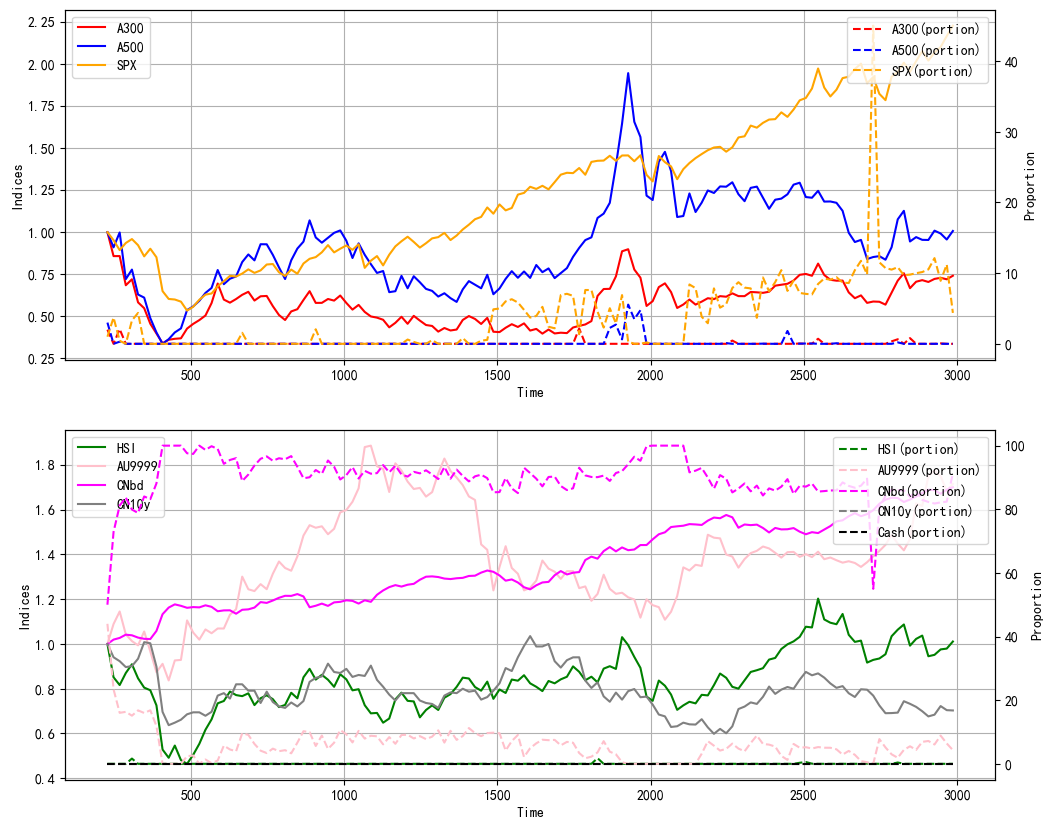

In [163]:
draw_ptf()

Start Date: 2008-01-02
End Date: 2020-01-10
Yearly Earning: 4.36%
Yearly Maximum Drawdown: -5.38%


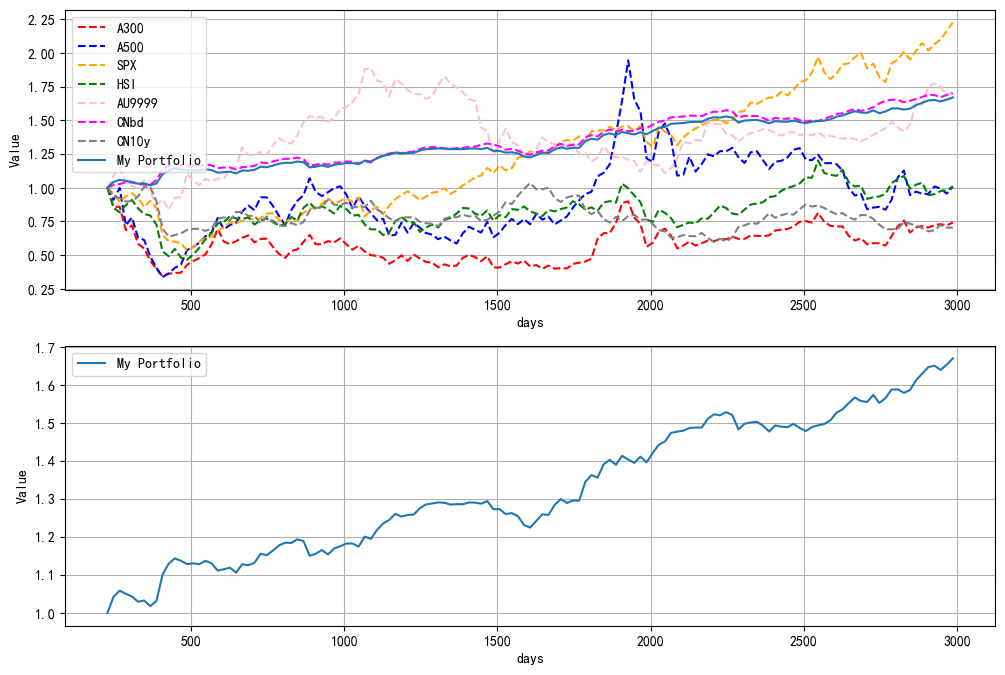

In [164]:
draw_profit()